# Conformal prediction with conditional coverage

This notebook investigates conformal prediction with conditional coverage. The goal is to:
1. Define a reasonable way to construct weight functions and use the weight function to define a sub population of the index set where the local conditional coverage of the marginal prediction intervals fall below the nomimal level.
2. Show by experiments that the weighted sampling model gives valid 'conditional coverage' in the sense that the new prediction intervals ahieves valid coverage marginally on the biased samples. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *  

(CVXPY) Apr 10 06:19:23 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')


## Find subset of indexes with poor estimation

In [4]:
# Define experiment parameters
m, n, r = 100,100,8
prop_obs = 0.6
alpha = 0.1
random_state = 1

Sampling uniformly from the noiseless random factorization model... 

Dark spots indicating the missing entries.


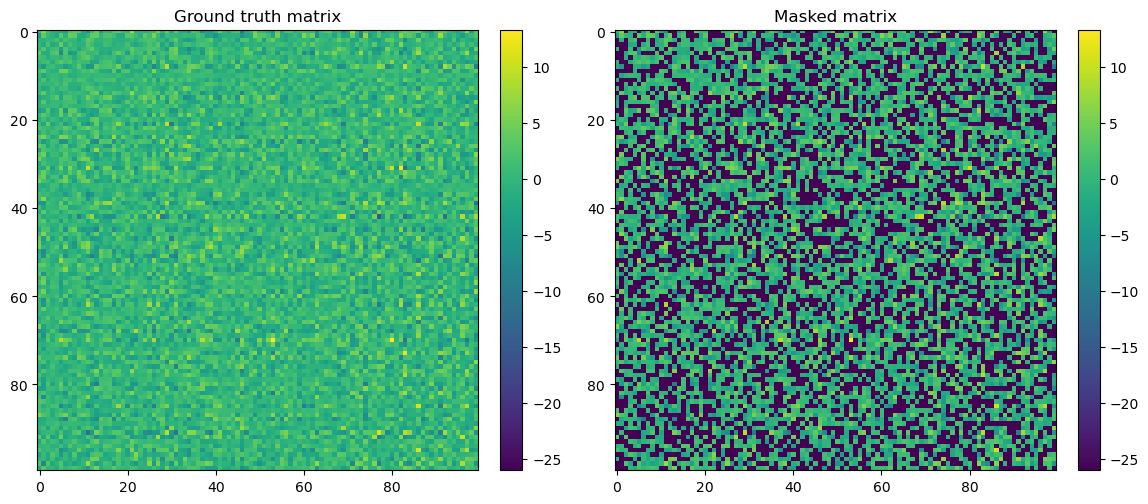

Observation size: 6000, training size: 4800, calib size: 1200


In [5]:
print('Sampling uniformly from the noiseless random factorization model... \n')
print('Dark spots indicating the missing entries.')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)

sampler = RandomSampling(m, n)
obs = sampler.sample_observed(prop_obs, random_state=random_state)
test = np.ones_like(obs) - obs
train, calib = sampler.sample_train_calib(obs, prob_calib=0.2, 
                                        random_state = random_state)
assert np.sum(train+calib==obs) == m*n,'Sampling error!'
vmin, vmax = np.min(M)-10, np.max(M)
plot_before_after_mask(M, obs, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}"
      .format(np.sum(obs), np.sum(train), np.sum(calib)))

In [6]:
# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 
scale = 1.2
w = np.arange(1, m*n+1)**scale/(m*n)
w = w/sum(w)

Sampling with weight from the noiseless random factorization model... 

Dark spots indicating the missing entries.


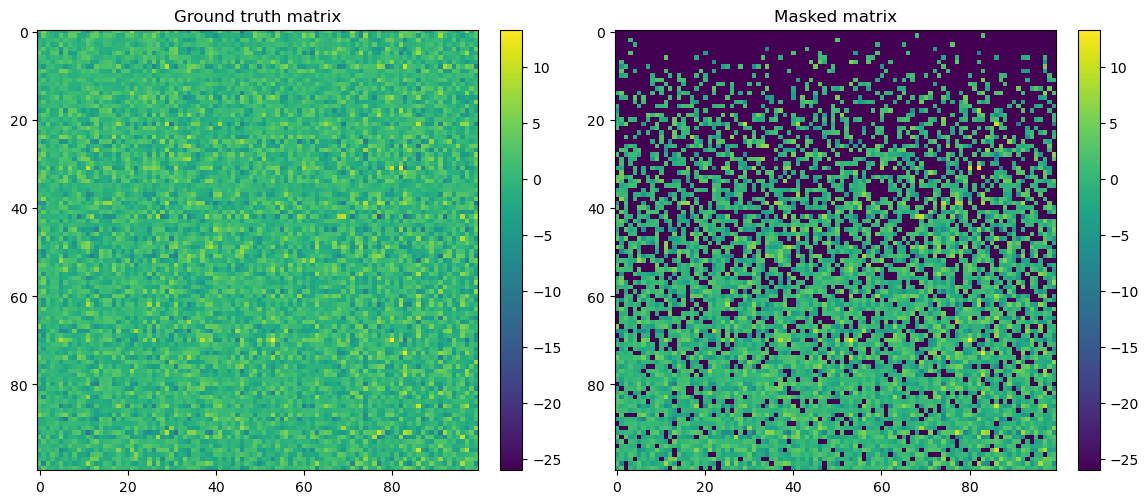

Observation size: 6000, training size: 4800, calib size: 1200


In [7]:
print('Sampling with weight from the noiseless random factorization model... \n')
print('Dark spots indicating the missing entries.')
obs_w = sampler.sample_observed(prop_obs, w=w, random_state=10)
test_w = np.ones_like(obs_w) - obs_w
train_w, calib_w = sampler.sample_train_calib(obs_w, prob_calib=0.2, 
                                            random_state = random_state)
assert np.sum(train_w+calib_w==obs_w) == m*n,'Sampling error!'
vmin, vmax = np.min(M)-10, np.max(M)
plot_before_after_mask(M, obs_w, vmin, vmax)
print("Observation size: {}, training size: {}, calib size: {}"
      .format(np.sum(obs_w), np.sum(train_w), np.sum(calib_w)))

In [8]:
print("Uniform sampling\n"+"-"*25)
print('Solving matrix completion with SVT...')
Mhat = svt_solve(M, train, random_state=random_state)
test_mse = evaluate_mse(M, Mhat, test)
train_mse = evaluate_mse(M, Mhat, train)
calib_mse = evaluate_mse(M, Mhat, calib)
print('train MSE: {}, calib MSE: {}, test MSE: {}'
      .format(train_mse, calib_mse, test_mse))

Uniform sampling
-------------------------
Solving matrix completion with SVT...
Iteration: 1; Rel error: 1.0000
Iteration: 11; Rel error: 0.1446
Iteration: 21; Rel error: 0.0585
Iteration: 31; Rel error: 0.0318
Iteration: 41; Rel error: 0.0193
Iteration: 51; Rel error: 0.0123
Iteration: 61; Rel error: 0.0081
Iteration: 71; Rel error: 0.0057
Iteration: 81; Rel error: 0.0041
Iteration: 91; Rel error: 0.0030
Iteration: 101; Rel error: 0.0022
Iteration: 111; Rel error: 0.0017
Iteration: 121; Rel error: 0.0012
Iteration: 131; Rel error: 0.0009
Iteration: 141; Rel error: 0.0007
Iteration: 151; Rel error: 0.0005
Iteration: 161; Rel error: 0.0004
Iteration: 171; Rel error: 0.0003
Iteration: 181; Rel error: 0.0002
Iteration: 191; Rel error: 0.0002
Iteration: 201; Rel error: 0.0001
Iteration: 211; Rel error: 0.0001
Stopping criteria met, training terminated.
train MSE: 8.050388717148296e-08, calib MSE: 8.526228232035305e-07, test MSE: 7.906331587549155e-07


In [9]:
print("Weighted sampling\n"+"-"*25)
print('Solving matrix completion with SVT...')
Mhat_w = svt_solve(M, train_w, random_state=random_state)
test_mse_w = evaluate_mse(M, Mhat_w, test_w)
train_mse_w = evaluate_mse(M, Mhat_w, train_w)
calib_mse_w = evaluate_mse(M, Mhat_w, calib_w)
print('train MSE: {}, calib MSE: {}, test MSE: {}'
      .format(train_mse_w, calib_mse_w, test_mse_w))

Weighted sampling
-------------------------
Solving matrix completion with SVT...
Iteration: 1; Rel error: 1.0000
Iteration: 11; Rel error: 0.1631
Iteration: 21; Rel error: 0.0757
Iteration: 31; Rel error: 0.0439
Iteration: 41; Rel error: 0.0299
Iteration: 51; Rel error: 0.0221
Iteration: 61; Rel error: 0.0180
Iteration: 71; Rel error: 0.0152
Iteration: 81; Rel error: 0.0127
Iteration: 91; Rel error: 0.0112
Iteration: 101; Rel error: 0.0101
Iteration: 111; Rel error: 0.0092
Iteration: 121; Rel error: 0.0086
Iteration: 131; Rel error: 0.0089
Iteration: 141; Rel error: 0.0125
Iteration: 151; Rel error: 0.0156
Iteration: 161; Rel error: 0.0160
Iteration: 171; Rel error: 0.0157
Iteration: 181; Rel error: 0.0153
Iteration: 191; Rel error: 0.0149
Iteration: 201; Rel error: 0.0146
Iteration: 211; Rel error: 0.0142
Iteration: 221; Rel error: 0.0141
Iteration: 231; Rel error: 0.0143
Iteration: 241; Rel error: 0.0145
Iteration: 251; Rel error: 0.0147
Iteration: 261; Rel error: 0.0147
Iteration: 

In [10]:
def error_heatmap(M, Mhat, mask, vmin=None, vmax=None, cmap=None):
    pred = np.multiply(Mhat, mask)
    truth = np.multiply(M, mask)
    residual = np.abs(pred-truth)
    residual = residual / np.max(residual)
    
    if cmap is None:
        cmap = plt.cm.get_cmap('viridis').reversed()
    if vmin is None: 
        vmin = 0
    if vmax is None: 
        # filter out some extreme values for better graph
        vmax = np.quantile(residual.flatten(), 0.95,method='higher')
    
    plt.figure(figsize=(6,4))
    plt.imshow(residual, cmap=cmap,vmin=vmin, vmax=vmax)
    plt.title("Absolute residuals")
    plt.colorbar()
    plt.show()


def residual_hist(M, Mhat, train_mask, calib_mask, test_mask,vmin=0, vmax=None):
    residual = np.abs(M-Mhat)
    #residual = residual / np.max(residual)   # normalize residuals
    res_train = residual[np.where(train_mask==1)]
    res_calib = residual[np.where(calib_mask==1)]
    res_test = residual[np.where(test_mask==1)]
    
    if vmax == None:
        vmax = np.quantile(residual.flatten(), 0.95,method='higher')
    bins = np.linspace(0, vmax, 100)

    plt.hist(res_train, bins, alpha=0.5, label='train')
    plt.hist(res_calib, bins, alpha=0.5, label='calib')
    plt.hist(res_test, bins, alpha=0.5, label='test')
    plt.legend(loc='upper right')
    plt.show()

Uniform sampling
-------------------------


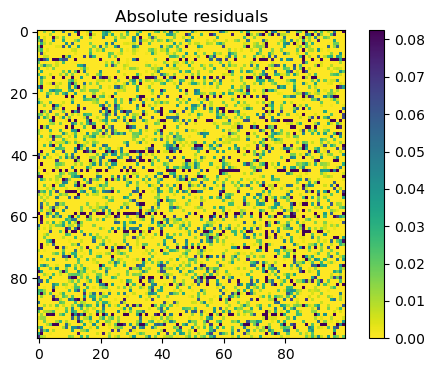

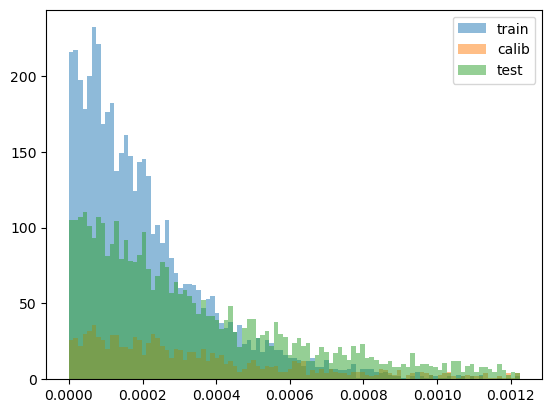

In [11]:
print("Uniform sampling\n"+"-"*25)
error_heatmap(M, Mhat, test)
residual_hist(M, Mhat, train, calib, test)

Weighted sampling
-------------------------


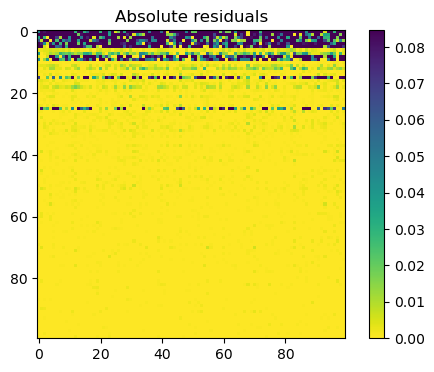

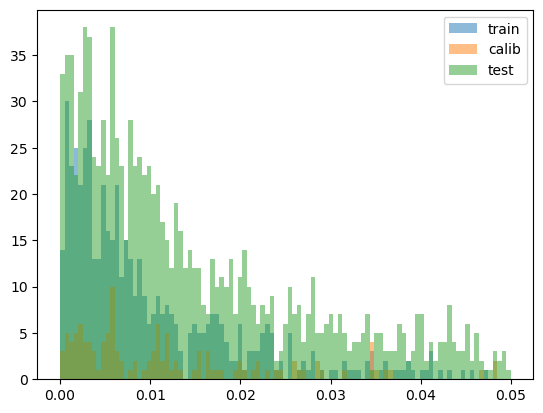

In [12]:
print("Weighted sampling\n"+"-"*25)
error_heatmap(M, Mhat_w, test_w)
# restricting the residuals on the first half of the matrix
residual_hist(M[:int(m*0.3)], Mhat_w[:int(m*0.3)], train_w[:int(m*0.3)],
              calib_w[:int(m*0.3)], test_w[:int(m*0.3)], vmax=0.05)

# residual_hist(M, Mhat_w, train_w,
#               calib_w, test_w, vmax=0.05)

## Experiments

We conduct some experiments with the toy models and compute the conformal prediction intervals for test points with the simplest scores based on estimation residuals for both exchangeble settings and covariate shift settings.

### Experiment 1: Fixing M, resample train, test, calib sets

In [13]:
def run_single_experiment(M, train_mask, test_mask, calib_mask, alpha, r= None, verbose=True, random_state=0):
    # Sanity check
    assert all(((train_mask + test_mask + calib_mask) <= 1).flatten()),\
           'Found error in sampling process, make sure splitted sets are disjoint'
        
    Mhat = svt_solve(M, train_mask, verbose=verbose, random_state=random_state)
    cpi = Conformal_PI()
    pi = cpi.marginal_PI(calib_mask, test_mask, M, Mhat, alpha)
    calib_mse = evaluate_mse(M, Mhat, calib_mask)
    train_mse = evaluate_mse(M, Mhat, train_mask)
    test_mse = evaluate_mse(M, Mhat, test_mask)
    
    results = evaluate_PI(pi, M[np.where(test_mask == 1)])
    results['Calib_MSE'] = [calib_mse]
    results['Train_MSE'] = [train_mse]
    results['Test_MSE'] = [test_mse]
    results['Alpha'] = [alpha]
    results['Seed'] = [random_state]
    results['Calib_size'] = [np.sum(calib_mask)]
    results['Train_size'] = [np.sum(train_mask)]
    
    # If the true rank or an estimation is given, approximate the minimal sufficient sample size 
    # for exact coverage.
    if r:
        results['Theory_size'] = [theoretical_bound(M.shape[0], M.shape[1], r, C=1)]
    return results

In [14]:
# Define experiment parameters
m, n, r = 100,100,8
prop_obs = 0.6
alpha = 0.1
repetition = 100

In [15]:
theoretical_bound(m, n, r, C=1)

11651.0

In [16]:
print('Fixing the ground truth matrix generated from the noiseless random orthogonal model.\n')
RFM = RandomFactorizationModel(m ,n, r)
U, V, M = RFM.sample_noiseless(random_state)
results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    random_state = i
    # Generate missing samples
    sampler = RandomSampling(m, n)
    obs = sampler.sample_observed(prop_obs, random_state=random_state)
    test = np.ones_like(obs) - obs
    train, calib = sampler.sample_train_calib(obs, prob_calib=0.2, 
                                            random_state = random_state)
    assert np.sum(train+calib==obs) == m*n,'Sampling error!'
    
    res = run_single_experiment(M, train, test, calib, 
                                alpha, r = r, verbose=False, random_state=random_state)
    
    results = pd.concat([results, res])

Fixing the ground truth matrix generated from the noiseless random orthogonal model.



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [06:26<00:00,  3.87s/it]


Uniform sampling
-------------------------
Test size is 4000, calibration size is 1200, training size is 4800, theoretical minimum training size is 11651.0


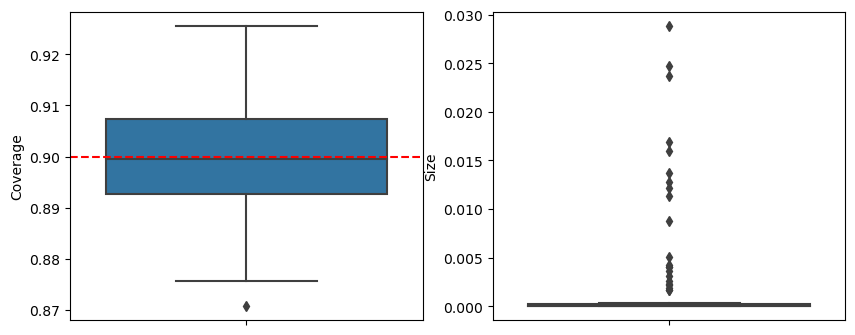

In [17]:
print("Uniform sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test), results['Calib_size'].iloc[0], 
              results['Train_size'].iloc[0], results['Theory_size'].iloc[0]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

In [18]:
# define the weights
# spatially determined weights, lower half of the indexes are more likely to
# be observed, for instance, a database with data ranked from oldest to newest
# and newer data are comprehensive. 
scale = 1.2
w = np.arange(1, m*n+1)**scale/(m*n)
w = w/sum(w)
assert all(w >= 0), 'Error in weights generation!'

In [19]:
results_w = pd.DataFrame({})

for i in tqdm(range(repetition)):
    random_state = i
    
    # Generate missing samples
    sampler = RandomSampling(m, n)
    obs = sampler.sample_observed(prop_obs, w=w, random_state=10)
    test = np.ones_like(obs) - obs
    train, calib = sampler.sample_train_calib(obs, prob_calib=0.2, 
                                                random_state = random_state)
    assert np.sum(train+calib==obs) == m*n,'Sampling error!'
    
    res = run_single_experiment(M, train, test, calib, 
                                alpha, r = r, verbose=False, random_state=random_state)
    
    results_w = pd.concat([results_w, res])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:53<00:00,  5.94s/it]


Weighted sampling
-------------------------
Test size is 4000, calibration size is 1200, training size is 4800, theoretical minimum training size is 11651.0


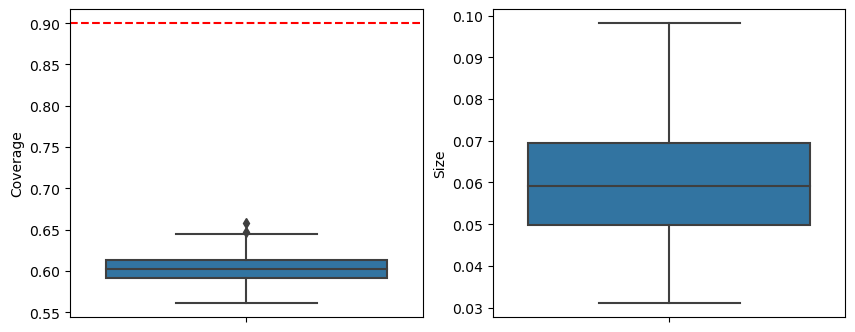

In [20]:
print("Weighted sampling\n"+"-"*25)
print('Test size is {}, calibration size is {}, training size is {}, theoretical minimum training size is {}'\
      .format(np.sum(test), results_w['Calib_size'].iloc[0], 
              results_w['Train_size'].iloc[0], results_w['Theory_size'].iloc[0]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.boxplot(y="Coverage", data=results_w, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1-alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_w, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

In [21]:
results_w

,Coverage,Size,Calib_MSE,Train_MSE,Test_MSE,Alpha,Seed,Calib_size,Train_size,Theory_size
0,0.61400,0.057799,0.028384,0.003425,0.924844,0.1,0,1200,4800,11651.0
0,0.62250,0.047664,0.027370,0.001985,0.858420,0.1,1,1200,4800,11651.0
0,0.57575,0.064487,0.044756,0.002564,0.915766,0.1,2,1200,4800,11651.0
0,0.61850,0.058192,0.044969,0.004299,0.934444,0.1,3,1200,4800,11651.0
0,0.60475,0.041967,0.028564,0.002864,0.855464,0.1,4,1200,4800,11651.0
...,...,...,...,...,...,...,...,...,...,...
0,0.61500,0.061129,0.044354,0.003753,0.932167,0.1,95,1200,4800,11651.0
0,0.62425,0.043276,0.017035,0.002224,0.848666,0.1,96,1200,4800,11651.0
0,0.60400,0.071630,0.055897,0.004715,0.955908,0.1,97,1200,4800,11651.0
0,0.58950,0.064159,0.033307,0.003779,0.925790,0.1,98,1200,4800,11651.0


In [22]:
results

,Coverage,Size,Calib_MSE,Train_MSE,Test_MSE,Alpha,Seed,Calib_size,Train_size,Theory_size
0,0.90800,1.266043e-09,6.420393e-19,3.696014e-20,5.946535e-19,0.1,0,1200,4800,11651.0
0,0.91125,4.314773e-12,3.385873e-24,3.160972e-25,3.148161e-24,0.1,1,1200,4800,11651.0
0,0.89700,1.626389e-03,2.346097e-06,1.240775e-06,2.091610e-06,0.1,2,1200,4800,11651.0
0,0.92050,2.200762e-03,3.567370e-06,2.764497e-06,3.366914e-06,0.1,3,1200,4800,11651.0
0,0.89625,8.740703e-03,3.269409e-04,1.645103e-04,3.408165e-04,0.1,4,1200,4800,11651.0
...,...,...,...,...,...,...,...,...,...,...
0,0.91350,1.279943e-05,1.491106e-10,2.492370e-11,1.542113e-10,0.1,95,1200,4800,11651.0
0,0.89600,9.833379e-11,2.025515e-21,1.666565e-22,2.472359e-21,0.1,96,1200,4800,11651.0
0,0.90250,5.338560e-08,5.648919e-16,1.266174e-16,7.228802e-16,0.1,97,1200,4800,11651.0
0,0.90350,3.765340e-05,1.064319e-09,5.444110e-10,6.159390e-10,0.1,98,1200,4800,11651.0
